In [1]:
import pandas as pd

# Load raw datasets (update paths accordingly)
kyc = pd.read_csv('C:/Users/metyu/OneDrive/Desktop/kyc.csv')
emt = pd.read_csv('C:/Users/metyu/OneDrive/Desktop/emt.csv')
wire = pd.read_csv('C:/Users/metyu/OneDrive/Desktop/wire.csv')
abm = pd.read_csv('C:/Users/metyu/OneDrive/Desktop/abm.csv')
cheque = pd.read_csv('C:/Users/metyu/OneDrive/Desktop/cheque.csv')
card = pd.read_csv('C:/Users/metyu/OneDrive/Desktop/card.csv')
eft = pd.read_csv('C:/Users/metyu/OneDrive/Desktop/eft.csv')

# Tag each with its source
emt['source'] = 'EMT'
wire['source'] = 'Wire'
abm['source'] = 'ABM'
cheque['source'] = 'Cheque'
card['source'] = 'Card'
eft['source'] = 'EFT'

# Concatenate all transactions
all_transactions = pd.concat([emt, wire, abm, cheque, card, eft], ignore_index=True)
all_transactions = pd.merge(all_transactions, kyc, on="customer_id", how="left")

# Convert numeric fields as needed
all_transactions['amount_cad'] = pd.to_numeric(all_transactions['amount_cad'], errors='coerce').fillna(0)


In [2]:
# Aggregate transactions per customer
customer_summary = all_transactions.groupby("customer_id").agg({
    "amount_cad": ["sum", "mean", "count"],
    "source": "nunique"
}).reset_index()

# Rename aggregated columns for clarity
customer_summary.columns = [
    "customer_id",
    "total_amount",
    "avg_amount",
    "transaction_count",
    "transaction_types"
]


In [3]:
# Load the labeled suspicious activity file (update path)
labeled_df = pd.read_csv('C:/Users/metyu/OneDrive/Desktop/suspicious_customers.csv')

# Create the binary label for each customer in customer_summary
customer_summary['is_suspicious'] = customer_summary['customer_id'].isin(labeled_df['customer_id']).astype(int)


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define input features and target
features = customer_summary[['total_amount', 'avg_amount', 'transaction_count', 'transaction_types']].values
X = features.reshape((features.shape[0], 1, features.shape[1]))  # reshape to 3D for LSTM
y = customer_summary['is_suspicious'].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
import tensorflow as tf

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true), axis=-1)

custom_objects = {
    'mse': mse
}

model_bi = tf.keras.models.load_model(
    'C:/Users/metyu/OneDrive/Desktop/model_lstm_bi.h5',
    custom_objects=custom_objects
)
model_lstm = tf.keras.models.load_model(
    'C:/Users/metyu/OneDrive/Desktop/model_lstm.h5',
    custom_objects=custom_objects
)

print("Bidirectional model input shape:", model_bi.input_shape)
print("Standard LSTM model input shape:", model_lstm.input_shape)


Bidirectional model input shape: (None, 256, 5)
Standard LSTM model input shape: (None, 10, 6)


In [6]:
import numpy as np

def pad_features(X, target_dim):
    """
    Adjusts feature dimension to the target_dim.
    If X has fewer columns, pads with zeros.
    If X has more, truncates.
    """
    n_samples, current_dim = X.shape
    if current_dim < target_dim:
        pad_width = target_dim - current_dim
        padding = np.zeros((n_samples, pad_width))
        return np.concatenate([X, padding], axis=1)
    elif current_dim > target_dim:
        return X[:, :target_dim]
    else:
        return X

def create_sequence(X, seq_length):
    """
    Repeats each sample to create a sequence of fixed length.
    This is a hack for aggregated data to match a sequence model.
    """
    # X is (samples, features); we need (samples, seq_length, features)
    return np.repeat(X[:, np.newaxis, :], seq_length, axis=1)

# Example: Let's assume your aggregated X_test is originally shape (n_samples, current_features)
# For demonstration, suppose:
print("Original X_test shape:", X_test.shape)  # e.g., (n_samples, 4)

# For Bidirectional LSTM (expects 256 timesteps and 5 features):
X_test_bi_features = pad_features(X_test.reshape(X_test.shape[0], -1), 5)  # now (n_samples, 5)
X_test_bi = create_sequence(X_test_bi_features, seq_length=256)             # now (n_samples, 256, 5)

# For Standard LSTM (expects 10 timesteps and 6 features):
X_test_lstm_features = pad_features(X_test.reshape(X_test.shape[0], -1), 6)  # now (n_samples, 6)
X_test_lstm = create_sequence(X_test_lstm_features, seq_length=10)           # now (n_samples, 10, 6)

# Now your X_test_bi and X_test_lstm should match the expected input shapes:
print("Adjusted Bidirectional X_test shape:", X_test_bi.shape)  # (n_samples, 256, 5)
print("Adjusted Standard LSTM X_test shape:", X_test_lstm.shape)  # (n_samples, 10, 6)


Original X_test shape: (3246, 1, 4)
Adjusted Bidirectional X_test shape: (3246, 256, 5)
Adjusted Standard LSTM X_test shape: (3246, 10, 6)


In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ======= STEP A: Adjust Your Aggregated Test Data =======
# Assume X_test is your aggregated test data with shape (3246, 1, 4)
print("Original X_test shape:", X_test.shape)  # Expected: (3246, 1, 4)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Now shape: (3246, 4)
print("Flattened X_test shape:", X_test_flat.shape)

def pad_features(X, target_dim):
    """
    Pads X (shape: (n_samples, current_dim)) to have target_dim columns.
    """
    n_samples, current_dim = X.shape
    if current_dim < target_dim:
        pad_width = target_dim - current_dim
        padding = np.zeros((n_samples, pad_width))
        X_padded = np.concatenate([X, padding], axis=1)
        return X_padded
    elif current_dim > target_dim:
        return X[:, :target_dim]
    else:
        return X

def create_sequence(X, seq_length):
    """
    Repeats each sample (row) to create a sequence of fixed length.
    Converts shape (n_samples, features) to (n_samples, seq_length, features)
    """
    return np.repeat(X[:, np.newaxis, :], seq_length, axis=1)

# For the Bidirectional LSTM (expects shape: (n_samples, 256, 5))
X_test_bi_features = pad_features(X_test_flat, 5)  # Now (3246, 5)
X_test_bi = create_sequence(X_test_bi_features, seq_length=256)  # Now (3246, 256, 5)
print("Adjusted Bidirectional X_test shape:", X_test_bi.shape)

# For the Standard LSTM (expects shape: (n_samples, 10, 6))
X_test_lstm_features = pad_features(X_test_flat, 6)  # Now (3246, 6)
X_test_lstm = create_sequence(X_test_lstm_features, seq_length=10)  # Now (3246, 10, 6)
print("Adjusted Standard LSTM X_test shape:", X_test_lstm.shape)

# ======= STEP B: Prepare y_test =======
# Ensure y_test is a 1D array.
print("Original y_test shape:", y_test.shape)
y_test = np.squeeze(y_test)
print("Flattened y_test shape:", y_test.shape)

# ======= STEP C: Evaluate the Bidirectional LSTM Model =======
# Predict using the bidirectional model (expected output shape: (3246, 256, 5))
y_pred_prob_bi_seq = model_bi.predict(X_test_bi)
print("Bidirectional raw prediction shape:", y_pred_prob_bi_seq.shape)  # Should be (3246, 256, 5)
# Extract the last timestep's prediction (assumes the probability is at index 0)
y_pred_prob_bi = y_pred_prob_bi_seq[:, -1, 0]
print("Extracted y_pred_prob_bi shape:", y_pred_prob_bi.shape)  # Expected: (3246,)
# Replace any NaNs with 0.0
y_pred_prob_bi = np.nan_to_num(y_pred_prob_bi, nan=0.0)
# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

print("=== Bidirectional LSTM Evaluation ===")
print(classification_report(y_test, y_pred_bi))
cm_bi = confusion_matrix(y_test, y_pred_bi)
print("Confusion Matrix:\n", cm_bi)
roc_auc_bi = roc_auc_score(y_test, y_pred_prob_bi)
print(f"ROC-AUC: {roc_auc_bi:.2f}")

# ======= STEP D: Evaluate the Standard LSTM Model =======
# Predict using the standard LSTM model (expected output shape: (3246, 10, 6))
y_pred_prob_lstm_seq = model_lstm.predict(X_test_lstm)
print("Standard LSTM raw prediction shape:", y_pred_prob_lstm_seq.shape)  # Should be (3246, 10, 6)
# Extract the last timestep's prediction (assumes the probability is at index 0)
y_pred_prob_lstm = y_pred_prob_lstm_seq[:, -1, 0]
print("Extracted y_pred_prob_lstm shape:", y_pred_prob_lstm.shape)  # Expected: (3246,)
y_pred_prob_lstm = np.nan_to_num(y_pred_prob_lstm, nan=0.0)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

print("=== Standard LSTM Evaluation ===")
print(classification_report(y_test, y_pred_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix:\n", cm_lstm)
roc_auc_lstm = roc_auc_score(y_test, y_pred_prob_lstm)
print(f"ROC-AUC: {roc_auc_lstm:.2f}")


Original X_test shape: (3246, 1, 4)
Flattened X_test shape: (3246, 4)
Adjusted Bidirectional X_test shape: (3246, 256, 5)
Adjusted Standard LSTM X_test shape: (3246, 10, 6)
Original y_test shape: (3246,)
Flattened y_test shape: (3246,)
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step
Bidirectional raw prediction shape: (3246, 256, 5)
Extracted y_pred_prob_bi shape: (3246,)
=== Bidirectional LSTM Evaluation ===
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2769
           1       0.00      0.00      0.00       477

    accuracy                           0.84      3246
   macro avg       0.43      0.49      0.46      3246
weighted avg       0.73      0.84      0.78      3246

Confusion Matrix:
 [[2723   46]
 [ 477    0]]
ROC-AUC: 0.05
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Standard LSTM raw prediction shape: (3246, 10, 6)
Extracted y_pred_prob_lstm shape: (3246,)
=== Standard LSTM Evaluation ===
              precision    recall  f1-s

In [8]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ----- Step 1: Adjust Aggregated Test Data -----
# Assume X_test is your aggregated test data with shape (3246, 1, 4)
print("Original X_test shape:", X_test.shape)  # Expected: (3246, 1, 4)

# Flatten X_test from (3246, 1, 4) to (3246, 4)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print("Flattened X_test shape:", X_test_flat.shape)  # Expected: (3246, 4)

def pad_features(X, target_dim):
    """
    Pads each sample in X (shape: (n_samples, current_dim))
    to have target_dim features. If current_dim < target_dim, pads with zeros;
    if greater, truncates.
    """
    n_samples, current_dim = X.shape
    if current_dim < target_dim:
        pad_width = target_dim - current_dim
        padding = np.zeros((n_samples, pad_width))
        X_padded = np.concatenate([X, padding], axis=1)
        print("Padded features shape:", X_padded.shape)  # Should be (n_samples, target_dim)
        return X_padded
    elif current_dim > target_dim:
        X_truncated = X[:, :target_dim]
        print("Truncated features shape:", X_truncated.shape)  # Should be (n_samples, target_dim)
        return X_truncated
    else:
        return X

def create_sequence(X, seq_length):
    """
    Repeats each sample (row) to create a sequence of fixed length.
    Converts (n_samples, features) to (n_samples, seq_length, features)
    """
    return np.repeat(X[:, np.newaxis, :], seq_length, axis=1)

# ----- For Bidirectional LSTM -----
# The model expects shape: (n_samples, 256, 5)
X_test_bi_features = pad_features(X_test_flat, 5)  # Should become (3246, 5)
X_test_bi = create_sequence(X_test_bi_features, seq_length=256)  # Now (3246, 256, 5)
print("Adjusted Bidirectional X_test shape:", X_test_bi.shape)  # Expected: (3246, 256, 5)

# ----- For Standard LSTM -----
# The model expects shape: (n_samples, 10, 6)
X_test_lstm_features = pad_features(X_test_flat, 6)  # Should become (3246, 6)
X_test_lstm = create_sequence(X_test_lstm_features, seq_length=10)  # Now (3246, 10, 6)
print("Adjusted Standard LSTM X_test shape:", X_test_lstm.shape)  # Expected: (3246, 10, 6)

# ----- Step 2: Prepare y_test -----
# Ensure y_test is 1D
print("Original y_test shape:", y_test.shape)
y_test = np.squeeze(y_test)
print("Flattened y_test shape:", y_test.shape)  # Expected: (3246,)

# ----- Step 3: Evaluate the Bidirectional LSTM Model -----
# model_bi is expected to accept input of shape (None, 256, 5)
print("Bidirectional model input shape:", model_bi.input_shape)

# Predict on the adjusted Bidirectional data
y_pred_prob_bi_seq = model_bi.predict(X_test_bi)
print("Bidirectional raw prediction shape:", y_pred_prob_bi_seq.shape)  # Should be (3246, 256, 5)
# Extract the last timestep's prediction (assumes probability is at index 0)
y_pred_prob_bi = y_pred_prob_bi_seq[:, -1, 0]
print("Extracted y_pred_prob_bi shape:", y_pred_prob_bi.shape)  # Expected: (3246,)
# Replace any NaNs with 0.0
y_pred_prob_bi = np.nan_to_num(y_pred_prob_bi, nan=0.0)
# Convert probabilities to binary predictions (threshold=0.5)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

print("=== Bidirectional LSTM Evaluation ===")
print(classification_report(y_test, y_pred_bi))
cm_bi = confusion_matrix(y_test, y_pred_bi)
print("Confusion Matrix:\n", cm_bi)
roc_auc_bi = roc_auc_score(y_test, y_pred_prob_bi)
print(f"ROC-AUC: {roc_auc_bi:.2f}")

# ----- Step 4: Evaluate the Standard LSTM Model -----
# model_lstm is expected to accept input of shape (None, 10, 6)
print("Standard LSTM model input shape:", model_lstm.input_shape)

# Predict on the adjusted Standard LSTM data
y_pred_prob_lstm_seq = model_lstm.predict(X_test_lstm)
print("Standard LSTM raw prediction shape:", y_pred_prob_lstm_seq.shape)  # Should be (3246, 10, 6)
# Extract the last timestep's prediction (assumes probability is at index 0)
y_pred_prob_lstm = y_pred_prob_lstm_seq[:, -1, 0]
print("Extracted y_pred_prob_lstm shape:", y_pred_prob_lstm.shape)  # Expected: (3246,)
y_pred_prob_lstm = np.nan_to_num(y_pred_prob_lstm, nan=0.0)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

print("\n=== Standard LSTM Evaluation ===")
print(classification_report(y_test, y_pred_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix:\n", cm_lstm)
roc_auc_lstm = roc_auc_score(y_test, y_pred_prob_lstm)
print(f"ROC-AUC: {roc_auc_lstm:.2f}")

# ----- Step 5: ROI Calculation -----
def compute_roi(conf_matrix, cost_fp=1000, cost_fn=10000):
    """
    Compute ROI given a confusion matrix:
    - conf_matrix: Format [[TN, FP], [FN, TP]]
    - cost_fp: Cost incurred per false positive
    - cost_fn: Loss avoided per true positive (cost per false negative)
    """
    tn, fp, fn, tp = conf_matrix.ravel()
    total_potential_loss = (tp + fn) * cost_fn
    savings = (tp * cost_fn) - (fp * cost_fp)
    roi_percentage = (savings / total_potential_loss) * 100 if total_potential_loss != 0 else 0
    return roi_percentage, savings, total_potential_loss

roi_bi, savings_bi, total_loss_bi = compute_roi(cm_bi)
roi_lstm, savings_lstm, total_loss_lstm = compute_roi(cm_lstm)

print("\n=== ROI Analysis ===")
print(f"Bidirectional LSTM: Savings = ${savings_bi}, Total Potential Loss = ${total_loss_bi}, ROI = {roi_bi:.2f}%")
print(f"Standard LSTM: Savings = ${savings_lstm}, Total Potential Loss = ${total_loss_lstm}, ROI = {roi_lstm:.2f}%")


Original X_test shape: (3246, 1, 4)
Flattened X_test shape: (3246, 4)
Padded features shape: (3246, 5)
Adjusted Bidirectional X_test shape: (3246, 256, 5)
Padded features shape: (3246, 6)
Adjusted Standard LSTM X_test shape: (3246, 10, 6)
Original y_test shape: (3246,)
Flattened y_test shape: (3246,)
Bidirectional model input shape: (None, 256, 5)
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step
Bidirectional raw prediction shape: (3246, 256, 5)
Extracted y_pred_prob_bi shape: (3246,)
=== Bidirectional LSTM Evaluation ===
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2769
           1       0.00      0.00      0.00       477

    accuracy                           0.84      3246
   macro avg       0.43      0.49      0.46      3246
weighted avg       0.73      0.84      0.78      3246

Confusion Matrix:
 [[2723   46]
 [ 477    0]]
ROC-AUC: 0.05
Standard LSTM model input shape: (None, 10, 6)
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Stan

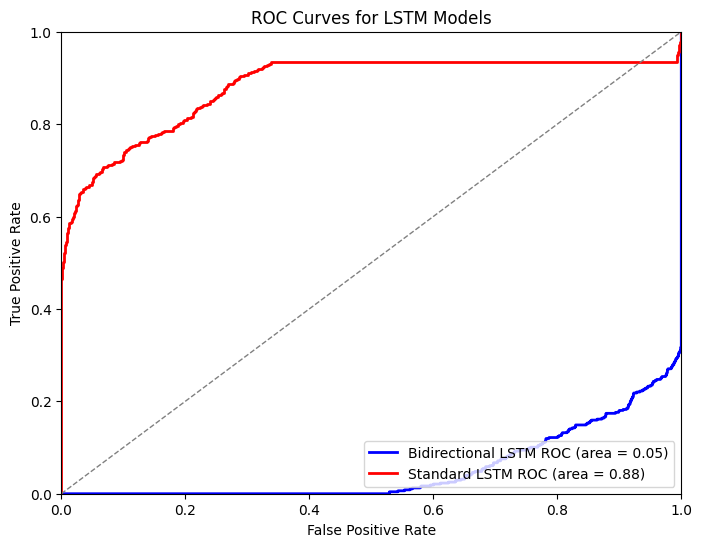

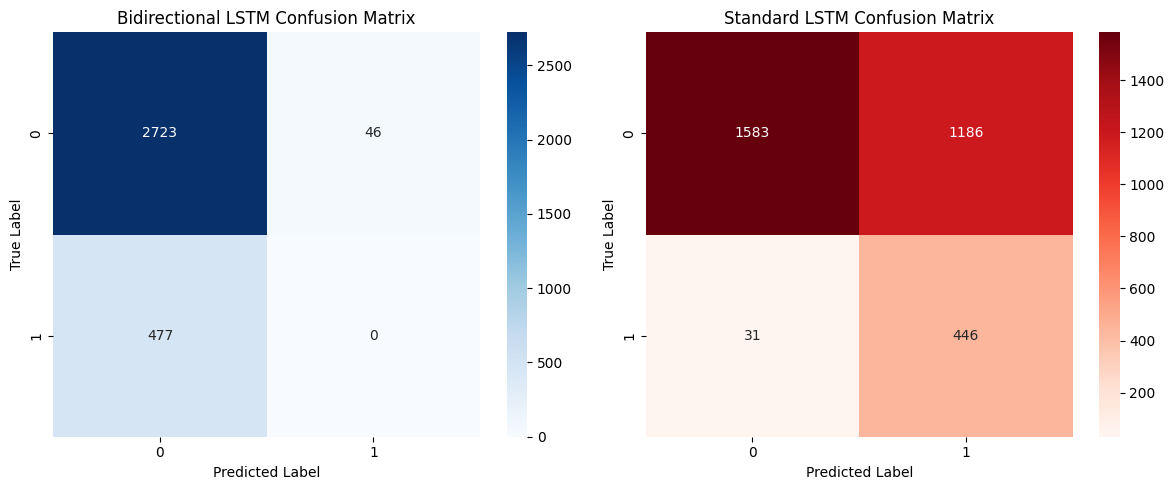

C:\Users\metyu\AppData\Local\Temp\ipykernel_10900\3305321031.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=roi_values, palette='viridis')


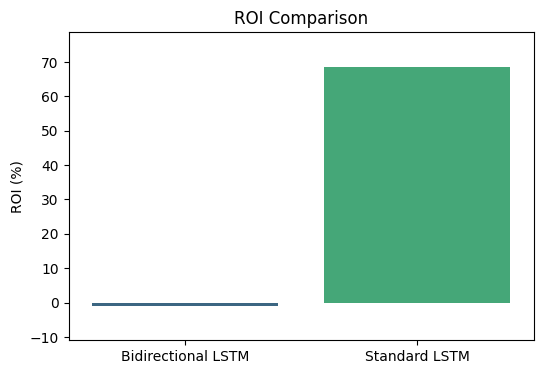

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# -------------------------------
# 1. ROC Curves
# -------------------------------
# Compute ROC curve for Bidirectional LSTM
fpr_bi, tpr_bi, thresholds_bi = roc_curve(y_test, y_pred_prob_bi)
roc_auc_bi_val = auc(fpr_bi, tpr_bi)

# Compute ROC curve for Standard LSTM
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm_val = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bi, tpr_bi, color='blue', lw=2,
         label='Bidirectional LSTM ROC (area = %0.2f)' % roc_auc_bi_val)
plt.plot(fpr_lstm, tpr_lstm, color='red', lw=2,
         label='Standard LSTM ROC (area = %0.2f)' % roc_auc_lstm_val)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for LSTM Models')
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# 2. Confusion Matrix Heatmaps
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_bi, annot=True, fmt="d", cmap='Blues', ax=axes[0])
axes[0].set_title('Bidirectional LSTM Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_lstm, annot=True, fmt="d", cmap='Reds', ax=axes[1])
axes[1].set_title('Standard LSTM Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# -------------------------------
# 3. ROI Comparison Bar Chart
# -------------------------------
# ROI values for each model
roi_values = [roi_bi, roi_lstm]
model_names = ['Bidirectional LSTM', 'Standard LSTM']

plt.figure(figsize=(6, 4))
sns.barplot(x=model_names, y=roi_values, palette='viridis')
plt.title('ROI Comparison')
plt.ylabel('ROI (%)')
plt.ylim(min(roi_values)-10, max(roi_values)+10)
plt.show()
